In [1]:
import os

import torch
from diffusion_openai.video_datasets import load_data
from metrics import apply_mask, average_deviation, compute_batch_mse, compute_batch_psnr, compute_batch_ssim
from PIL import Image, ImageSequence

In [2]:
original = load_data(
    data_dir="/home/s_gladkykh/thesis/sky-diffusion/ramvid_notebooks/original_for_evaluation",
    batch_size=99,
    image_size=64,
    class_cond=False,
    deterministic=True,
    rgb=True,
    seq_len=20
)

fake = load_data(
    data_dir="/home/s_gladkykh/thesis/sky-diffusion/ramvid_notebooks/generated_for_evaluation",
    batch_size=99,
    image_size=64,
    class_cond=False,
    deterministic=True,
    rgb=True,
    seq_len=20
)

In [3]:
original, _ = next(iter(original))
generated, _ = next(iter(fake))

In [4]:
original_seq = [torch.squeeze(original.permute(0, 2, 1, 3, 4)[:,i:i+1], dim=1) for i in range(20)]
generated_seq = [torch.squeeze(generated.permute(0, 2, 1, 3, 4)[:,i:i+1], dim=1) for i in range(20)]

In [5]:
original_seq[0].shape

torch.Size([99, 3, 64, 64])

In [6]:
ssims = []
psnrs = []
mses = []
cov_mses = []
for real, fake in zip(original_seq, generated_seq):
    ssims.append(compute_batch_ssim(real, fake))
    psnrs.append(compute_batch_psnr(real, fake))
    mses.append(compute_batch_mse(real, fake))

    real_mask = apply_mask((real * 255))
    fake_mask = apply_mask((fake * 255))
    cov_mses.append([((i - j)**2).mean().item()*100 for i,j in zip(fake_mask, real_mask)])

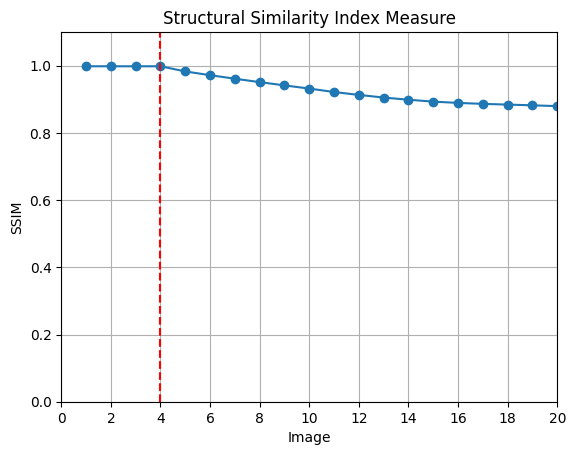

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator


plt.plot(list(range(1, 21, 1)), ssims, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Add labels and title
plt.title('Structural Similarity Index Measure')
plt.xlabel('Image')
plt.ylabel('SSIM')
plt.xlim(0, 20)
plt.ylim(0, 1.1)
# Show grid
plt.grid(True)

plt.savefig("ssim_ramvid.png")

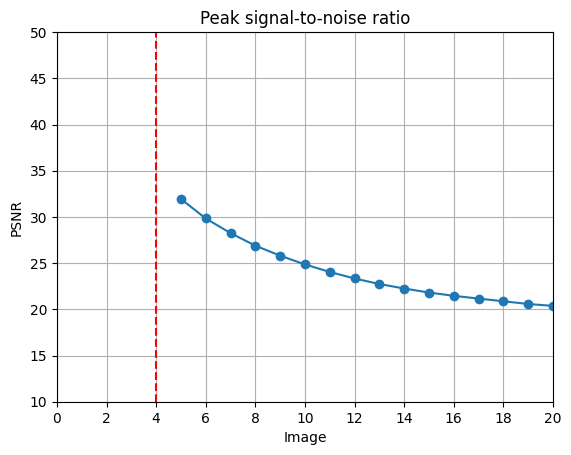

In [8]:
for i in range(4):
    psnrs[i] = None

plt.plot(list(range(1, 21, 1)), psnrs, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Add labels and title
plt.title('Peak signal-to-noise ratio')
plt.xlabel('Image')
plt.ylabel('PSNR')
plt.xlim(0, 20)
plt.ylim(10, 50)
# Show grid
plt.grid(True)


# Show plot
# plt.savefig("fid_uncond.png")
plt.savefig("psnr_ramvid.png")

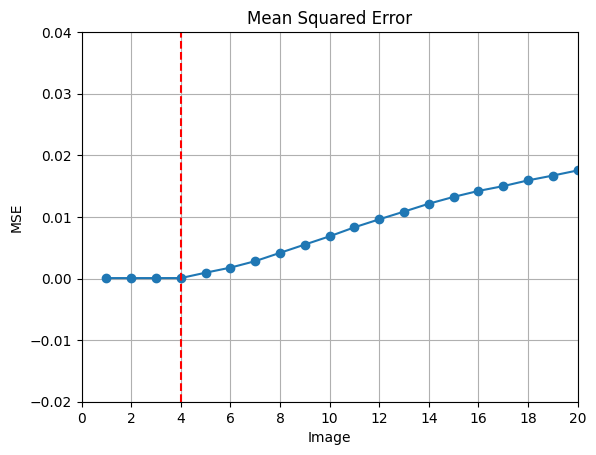

In [9]:
plt.plot(list(range(1, 21, 1)), mses, marker='o')
plt.axvline(x=4, color='r', linestyle='--')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Add labels and title
plt.title('Mean Squared Error')
plt.xlabel('Image')
plt.ylabel('MSE')
plt.xlim(0, 20)
plt.ylim(-0.02, 0.04)
# Show grid
plt.grid(True)


# Show plot
plt.savefig("mse_ramvid.png")

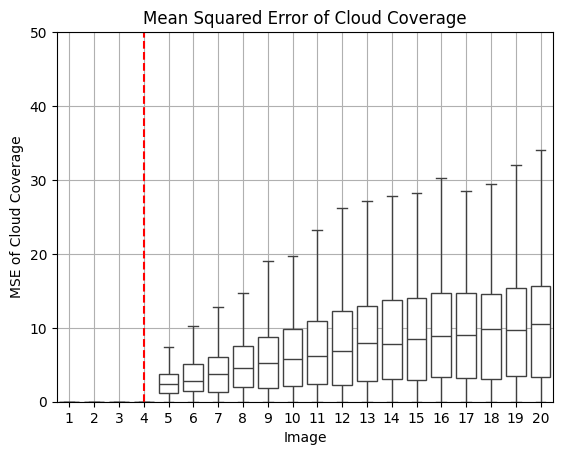

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('seaborn-whitegrid')
plt.style.use('default')
for i in range(4):
    cov_mses[i] = 0

sns.boxplot(data=cov_mses, showfliers=False, color='white')
plt.axvline(x=3, color='r', linestyle='--')
plt.ylim(0, 50)
plt.xticks(ticks=range(len(cov_mses)), labels=[i+1 for i in range(len(cov_mses))])
plt.grid(True)
plt.title('Mean Squared Error of Cloud Coverage')
plt.xlabel('Image')
plt.ylabel('MSE of Cloud Coverage')
plt.savefig("cc_mse_ramvid.png")

In [11]:
mses[-1]

0.01754969358444214

In [12]:
average_deviation(cov_mses[11])

5.410550820707071

In [13]:
average_deviation(cov_mses[-1])

7.184908387855831

In [21]:
def separate_gif_frames(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".gif"):
            gif_path = os.path.join(input_dir, filename)
            gif = Image.open(gif_path)
            frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
            for i, frame in enumerate(frames):
                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{i+1}.png")
                frame.save(output_path, format="PNG")

input_directory = "original_for_evaluation"
output_directory = "originals"
separate_gif_frames(input_directory, output_directory)